### Importing libraries and defining the PDE model of CICR with sink

In [1]:
"""
1. Detailed comments about model implementation can be found within 1D-CICR-model-v0.ipynb

2. The notebook contains imports of data generated using sampling of parameters for Supplementary Figure 11A. The code 
   for generating this data can be found within parameter-screening directory.
   
3. The notebook contains plots for Figure 6 and Supplementary Figure 11 of the manuscript
"""

import os
import time
import numpy as np
import scipy.stats as st
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import numba
from smt.sampling_methods import LHS

@numba.njit
def release_calcium(t, t_i, sigma, tau, dSites):
    if t >= t_i and t <= t_i + tau:
        return sigma
    else:
        return 0
    
@numba.njit
def source_calcium(t, src_strength, src_rise_time):
    if t <= src_rise_time:
        return src_strength
    else:
        return 0
    
@numba.njit
def cicr_ros_diff(Ca, dx, dt, time_steps, theta):
    ### Defining model parameters
    src_center_strength = theta[0]
    src_center_actTime = theta[1]
    sigma = theta[2] 
    tau = theta[3] 
    d_sites = theta[4]
    Ca_threshold = theta[5]
    km = theta[6]
    nsink = theta[7]
    vmax = theta[8]
    D = 1200
    
    Ca_basal = 0.1
    Ca = Ca + Ca_basal
    
    L = 700
    points2 = np.arange(350+d_sites, 600, d_sites)
    points1List = []
    temp = 350
    for i in range(len(points2)):
        temp = temp - d_sites
        points1List.append(temp)
    points1Numpy = np.array(points1List)
    points1 = points1Numpy[::-1]
    x_sites = np.concatenate((points1, points2))
    fired = np.zeros(len(x_sites), dtype=numba.boolean) ## np.zeros(len(x_sites), dtype=bool)
    fired_init_times = np.zeros(len(x_sites)) 
    
    idx_center = int(350 / dx)
    
    ### Solving reaction diffusion equations
    for t in range(1, time_steps): 
        
        ### Solving for diffusion
        Ca[1:-1, t] = Ca[1:-1, t-1] + D * dt / dx**2 * (Ca[2:, t-1] - 2 * Ca[1:-1, t-1] + Ca[:-2, t-1])
        Ca[0, t] = Ca_basal
        Ca[-1, t] = Ca_basal
        
        ### Adding sink
        sink_term = (vmax * ((Ca[:, t-1] - Ca_basal)**nsink)) / (km**nsink + (Ca[:, t-1]- Ca_basal)**nsink)
        Ca[:, t] -= dt * sink_term 
        
        ### Defining source at the center 
        Ca[idx_center,t]+= dt*source_calcium(t*dt, src_center_strength, src_center_actTime)
        
        ### Modeling CICR
        for i, x_i in enumerate(x_sites):
            idx = int(x_i / dx)
            if not fired[i] and Ca[idx, t-1] >= Ca_threshold:
                fired[i] = True  
                fired_init_times[i] = t * dt    
            if fired[i]:
                Ca[idx, t] += dt* release_calcium(t*dt, fired_init_times[i], sigma, tau, d_sites)
                
    return Ca, x_sites, fired_init_times, fired, points2

def plotting_functions(Ca, x_sites, fired_init_times, ctr):
    Ca_size_in_gb = Ca.nbytes / (1024 ** 3) 
    memory_threshold_gb = 1.0
    if np.all(np.isfinite(Ca)):
        output_folder = 'output_data_analysis'
        os.makedirs(output_folder, exist_ok=True)
        fig, axs = plt.subplots(1, 1, figsize=(2.8, 3), dpi=200)
        Ca_sliced = Ca[:, ::100]
        half_index = Ca_sliced.shape[0] // 2
        Ca_sliced_half = Ca_sliced[half_index:, :]
        im1 = axs.imshow(Ca_sliced_half, extent=[0, 4, 0, 350], aspect='auto', origin='lower', 
                         interpolation='nearest',vmin = 0.1, vmax = 0.45)
        fig.colorbar(im1, ax=axs, label=r'$[Ca^{2+}]$ ($\mu M$)')
        time_points1 = np.linspace(0, 3.85, 100)
        y_positions1 = (1.35-0.27)* 60 * time_points1 ##+ 350
        axs.plot(time_points1, y_positions1, 'whitesmoke', linewidth=1.5, linestyle = '-')
        time_points2 = np.linspace(0, 2.57, 100)
        y_positions2 = (1.35+0.27)* 60 * time_points2 ##+ 350
        axs.plot(time_points2, y_positions2, 'whitesmoke', linewidth=1.5, linestyle = '-')
        axs.hlines(y=50, xmin=0, xmax=4, color='whitesmoke', linewidth=1.5, linestyle='-')
        axs.hlines(y=200, xmin=0, xmax=4, color='whitesmoke', linewidth=1.5, linestyle='-')
        axs.scatter(fired_init_times, x_sites-350, c='tab:red', s=10)
        axs.set_ylim(0, 350)
        axs.set_xlim(0, 4)
        axs.set_xlabel('time (min)')
        axs.set_ylabel('position (µm)')        
        filename = os.path.join(output_folder, 'Figure_' + str(ctr) + '.svg')
        plt.tight_layout()
        plt.savefig(filename)
        plt.close(fig)
    else:
        print('Exceeds memory use.')
        
def main_model_1(theta, ctr):
    
    dx = 0.2 
    T = 4  
    dt = 0.00001  
    time_steps = int(T / dt)
    L = 700
    x = np.arange(0, L, dx)
    n = len(x)
    Ca = np.zeros((n, time_steps))
    
    ### Solving the CICR model
    Ca, x_sites, fired_init_times, fired, points2 = cicr_ros_diff(Ca, dx, dt, time_steps, theta) 
    indices = np.where(np.isin(x_sites, points2))[0]
    filtered_fired = fired[indices]
    filtered_fired_init_times = fired_init_times[indices]
    
    ### Plotting functions
    if np.max(np.max(Ca)) < 100:
        fired_indices = np.where(filtered_fired)[0]
        if len(fired_indices) > 1:
            first_fired_index = fired_indices[np.argmin(filtered_fired_init_times[fired_indices])]
            last_fired_index = fired_indices[np.argmax(filtered_fired_init_times[fired_indices])]
            middle_fired_index = fired_indices[len(fired_indices) // 2]
            
            # Extract calcium concentrations for the first, middle, and last fired points
            Ca_first_fired = Ca[int(points2[first_fired_index] / dx), :]
            Ca_middle_fired = Ca[int(points2[middle_fired_index] / dx), :]
            Ca_last_fired = Ca[int(points2[last_fired_index] / dx), :]
            
            total_distance = points2[last_fired_index] - points2[first_fired_index]
            total_time = filtered_fired_init_times[last_fired_index] - filtered_fired_init_times[first_fired_index]
            average_velocity = total_distance / total_time if total_time != 0 else 10000
            
            yVar = points2[fired_indices]
            xVar = filtered_fired_init_times[fired_indices]
            slope, intercept, r_value, p_value, std_err = stats.linregress(xVar, yVar)
            y_pred = intercept + slope * xVar
            ss_res = np.sum((yVar - y_pred) ** 2) 
            ss_tot = np.sum((yVar - np.mean(yVar)) ** 2)  
            r_squared = 1 - (ss_res / ss_tot)            
            """
            ### Uncomment this to enable plotting
            try:
                plotting_functions(Ca, x_sites, fired_init_times, ctr)
            except Exception as e:
                print('Not succesful in saving this one')
            """
        else:
            average_velocity = 0
            total_distance = 0
            
    else:
        average_velocity = 0
        total_distance = 0
    
    return average_velocity, total_distance, r_squared, Ca_first_fired, Ca_middle_fired, Ca_last_fired

### Supplementary Figure 11D

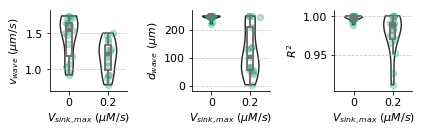

In [3]:
"""
This part is used to visualize the wave statistics post adding a sink for all the model parameters
that yielded a wave velocity in biologically permissible range for 1uM flg22 treatment
"""
"""
Code for generating data
"""
"""
theta_master = np.load('output-data-15000/theta_master.npy')
wave_velocity_master = np.load('output-data-15000/wave_velocity_master.npy')

vel_exp = [53.4, 61.8, 62.4, 63.6, 74.4, 76.2, 84,
           84.6, 86.4, 90.6, 92.4, 97.8, 102, 105.6]

vel_min = min(vel_exp)
vel_max = max(vel_exp)
mask = (wave_velocity_master >= vel_min) & (wave_velocity_master <= vel_max)
wave_velocity_filtered = wave_velocity_master[mask]
theta_filtered = theta_master[mask]
theta_filtered[:, :4] = 10 ** theta_filtered[:, :4]
wave_velocity_subset = wave_velocity_filtered[theta_filtered[:, 3] <= 0.5]
theta_filtered_subset = theta_filtered[theta_filtered[:, 3] <= 0.5]
indices_cicr_pos = [12, 33, 36, 48, 89, 91, 99, 103, 174, 187, 198, 
                    217, 226, 243, 317, 324, 331, 332]
theta_filtered_subset = theta_filtered_subset[indices_cicr_pos,:]
wave_velocity_subset = wave_velocity_subset[indices_cicr_pos]
theta01 = np.array([2.00270355e+02, 1.95119197e-01, 1.50008776e+00, 4.18697145e-01, 5.69583333e-01, 2.05740000e-01, 0.1, 2, 0])
theta02 = np.array([2.00270355e+02, 1.95119197e-01, 1.50008776e+00, 4.18697145e-01, 5.69583333e-01, 2.05740000e-01, 0.1, 2, 0.2])

wave_velocities_1 = np.zeros(len(theta_filtered_subset))
wave_velocities_2 = np.zeros(len(theta_filtered_subset))
wave_distances_1 = np.zeros(len(theta_filtered_subset))
wave_distances_2 = np.zeros(len(theta_filtered_subset))
wave_rsquared_1 = np.zeros(len(theta_filtered_subset))
wave_rsquared_2 = np.zeros(len(theta_filtered_subset))

ca_first_master = []
ca_middle_master = []
ca_last_master = []

for i, theta in enumerate(theta_filtered_subset):
    
    theta_1 = theta01.copy()
    theta_2 = theta02.copy()
    theta_1[:6] = theta
    theta_2[:6] = theta
    
    wave_vel_1, dis1, rsq1, dummy1, dummy2, dummy3  = main_model_1(theta_1, ctr=0) 
    wave_vel_2, dis2, rsq2, caf, cam, cal = main_model_1(theta_2, ctr=0)

    wave_velocities_1[i] = wave_vel_1
    wave_velocities_2[i] = wave_vel_2
    wave_distances_1[i] = dis1
    wave_distances_2[i] = dis2
    wave_rsquared_1[i] = rsq1
    wave_rsquared_2[i] = rsq2
    ca_first_master.append(caf)
    ca_middle_master.append(cam)
    ca_last_master.append(cal)
"""


### Loading data for analysis
### Index 1 represents values for model without a sink
### Index 2 represents values for model with sink (Vsink,max = 0.2)

## Data 1
wave_distances_1 = np.load('data1/wave_distances_1.npy') 
wave_distances_2 = np.load('data1/wave_distances_2.npy')
wave_rsquared_1 = np.load('data1/wave_rsquared_1.npy')
wave_rsquared_2 = np.load('data1/wave_rsquared_2.npy')
wave_velocities_1 = np.load('data1/wave_velocities_1.npy')
wave_velocities_2 = np.load('data1/wave_velocities_2.npy')
### Filtering data 1
wave_distances_11 = wave_distances_1[wave_distances_1 != 0]
wave_distances_21 = wave_distances_2[wave_distances_2 != 0]
wave_rsquared_11 = wave_rsquared_1[wave_rsquared_1 != 0]
wave_rsquared_21 = wave_rsquared_2[wave_rsquared_2 != 0]
wave_velocities_11 = wave_velocities_1[wave_velocities_1 != 0]
wave_velocities_21 = wave_velocities_2[wave_velocities_2 != 0]

### Data 2
wave_distances_1 = np.load('data2/wave_distances_1.npy')
wave_distances_2 = np.load('data2/wave_distances_2.npy')
wave_rsquared_1 = np.load('data2/wave_rsquared_1.npy')
wave_rsquared_2 = np.load('data2/wave_rsquared_2.npy')
wave_velocities_1 = np.load('data2/wave_velocities_1.npy')
wave_velocities_2 = np.load('data2/wave_velocities_2.npy')
### Filtering data 2
wave_distances_12 = wave_distances_1[wave_distances_1 != 0]
wave_distances_22 = wave_distances_2[wave_distances_2 != 0]
wave_rsquared_12 = wave_rsquared_1[wave_rsquared_1 != 0]
wave_rsquared_22 = wave_rsquared_2[wave_rsquared_2 != 0]
wave_velocities_12 = wave_velocities_1[wave_velocities_1 != 0]
wave_velocities_22 = wave_velocities_2[wave_velocities_2 != 0]

### Combining data 1 and data 2
merged_wave_distances_1 = np.concatenate((wave_distances_11, wave_distances_12))
merged_wave_distances_2 = np.concatenate((wave_distances_21, wave_distances_22))
merged_wave_rsquared_1 = np.concatenate((wave_rsquared_11, wave_rsquared_12))
merged_wave_rsquared_2 = np.concatenate((wave_rsquared_21, wave_rsquared_22))
merged_wave_velocities_1 = np.concatenate((wave_velocities_11, wave_velocities_12))
merged_wave_velocities_2 = np.concatenate((wave_velocities_21, wave_velocities_22))

"""
Creating plots
"""

GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

### Defining figure metrics
fig, ax = plt.subplots(1, 3, figsize=(6, 2))
plt.rcParams.update({'font.size': 11})
POSITIONS = [0,1]
### Values of Vsink,max 
x_label = ('0','0.2')

### Plot for wave velocity comparison on adding sink
a = (merged_wave_velocities_1.copy())/60 
b = (merged_wave_velocities_2.copy())/60 
b = b[b<2]
y_data = [a, b]
violins = ax[0].violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
medianprops = dict(linewidth=4, color=GREY_DARK,solid_capstyle="butt")
boxprops = dict(linewidth=2, color=GREY_DARK)
ax[0].boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, 
    showcaps = False,   
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops)    
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3", "#1B9E77", "#D95F02", "#7570B3", "#1B9E77", "#D95F02", "#7570B3"]
COLOR_SCALE = ["#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77"]
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax[0].scatter(x, y, s=40, alpha=0.3, color=color)
ax[0].set_xlabel(r'$V_{sink,max}$ ($\mu M/s$)', fontsize = 11)
ax[0].set_ylabel(r'$v_{wave}$ ($\mu m/s$)', fontsize = 11)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xticklabels(x_label, rotation=0)

### Plot for distance travelled by wave 
a = (merged_wave_distances_1.copy()) 
b = (merged_wave_distances_2.copy()) 
y_data = [a, b]
violins = ax[1].violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
medianprops = dict(linewidth=4, color=GREY_DARK,solid_capstyle="butt")
boxprops = dict(linewidth=2, color=GREY_DARK)
ax[1].boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, 
    showcaps = False,   
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)    
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3", "#1B9E77", "#D95F02", "#7570B3", "#1B9E77", "#D95F02", "#7570B3"]
COLOR_SCALE = ["#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77"]
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax[1].scatter(x, y, s=40, alpha=0.3, color=color)
ax[1].set_xlabel(r'$V_{sink,max}$ ($\mu M/s$)', fontsize = 11)
ax[1].set_ylabel(r'$d_{wave}$ ($\mu m$)', fontsize = 11)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xticklabels(x_label, rotation=0)

### Plot for Rsquared values for linear regression model fit to teh wave velocity data
a = (merged_wave_rsquared_1.copy()) 
b = (merged_wave_rsquared_2.copy()) 
y_data = [a, b]
violins = ax[2].violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
medianprops = dict(linewidth=4, color=GREY_DARK,solid_capstyle="butt")
boxprops = dict(linewidth=2, color=GREY_DARK)
ax[2].boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, 
    showcaps = False,   
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops)    
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3", "#1B9E77", "#D95F02", "#7570B3", "#1B9E77", "#D95F02", "#7570B3"]
COLOR_SCALE = ["#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77"]
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax[2].scatter(x, y, s=40, alpha=0.3, color=color)
ax[2].set_xlabel(r'$V_{sink,max}$ ($\mu M/s$)', fontsize = 11)
ax[2].set_ylabel(r'$R^{2}$', fontsize = 11)
ax[2].grid(axis='y', linestyle='--', alpha=0.7)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xticklabels(x_label, rotation=0)

plt.tight_layout()
plt.show()

**Supplementary Figure 11D** *For each parameter set producing wave velocities within the experimental range (Figure 1A), the parameter Vsink,max was added to the model and set to a value of 0.2 μM/min as shown on the x-axis. A box-and-whisker plot displays the distribution of (i) wave velocities (v) (ii) wave propagation distances (dwave), and (iii) R2 values resulting from the inclusion of a sink in the model. The box spans the interquartile range (IQR), with whiskers extending to 1.5 times the IQR, and the horizontal line within the box indicates the median.*

### Supplementary Figure 11E

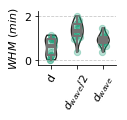

In [4]:
"""
For each parameter value where a sink was added, calcium concentration over time was stored and saved in last step at 
three distinct locations: i) Near the center of domain / initiator site ii) At the middle of overall wave propagation distance.
iii) At the end of teh wave trabel distance. 

We extract width at half max for the calcium concentrations at different points and show the distribution for all the parameter
values where a sink was added. 

"""

### Loading data generated in last step (see previous cell)
ca_first_master = np.load('data1/ca_first_master.npy')
ca_last_master = np.load('data1/ca_last_master.npy')
ca_middle_master = np.load('data1/ca_middle_master.npy')
ca_first_master1 = ca_first_master.copy()
ca_last_master1 = ca_last_master.copy()
ca_middle_master1 = ca_middle_master.copy()
ca_first_master = np.load('data2/ca_first_master.npy')
ca_last_master = np.load('data2/ca_last_master.npy')
ca_middle_master = np.load('data2/ca_middle_master.npy')
ca_first_master2 = ca_first_master.copy()
ca_last_master2 = ca_last_master.copy()
ca_middle_master2 = ca_middle_master.copy()
ca_first_master = np.concatenate((ca_first_master1, ca_first_master2), axis=0)
ca_last_master = np.concatenate((ca_last_master1, ca_last_master2), axis=0)
ca_middle_master = np.concatenate((ca_middle_master1, ca_middle_master2), axis=0)

T = 4  
dt = 0.00001  
time_steps = int(T / dt)
time = np.linspace(0, T, time_steps)

whm_first = []
whm_middle = []
whm_last = []

### Iterating through all the param values where a sink was added
for j in range(len(ca_first_master)):
    ### Extracting width at half maximum near the center of domain / initiator site
    Ca_fired = ca_first_master[j,:]
    max_value = np.max(Ca_fired)
    max_time = time[np.argmax(Ca_fired)]
    half_max_value = 0.1 + (max_value - 0.1) / 2
    above_half_max = np.where(Ca_fired >= half_max_value)[0]
    half_max_rising_idx = above_half_max[0]  
    half_max_falling_idx = above_half_max[-1]  
    half_max_rising_time = time[half_max_rising_idx]
    half_max_falling_time = time[half_max_falling_idx]
    whm = half_max_falling_time - half_max_rising_time
    whm_first.append(whm)
    
    ### Extracting width at half maximum near the middle of overall wave propagation distance
    Ca_fired = ca_middle_master[j,:]
    max_value = np.max(Ca_fired)
    max_time = time[np.argmax(Ca_fired)]
    half_max_value = 0.1 + (max_value - 0.1) / 2
    above_half_max = np.where(Ca_fired >= half_max_value)[0]
    half_max_rising_idx = above_half_max[0]  
    half_max_falling_idx = above_half_max[-1]  
    half_max_rising_time = time[half_max_rising_idx]
    half_max_falling_time = time[half_max_falling_idx]
    whm = half_max_falling_time - half_max_rising_time
    whm_middle.append(whm)
    
    ### Extracting width at half maximum near the end of overall wave propagation distance
    Ca_fired = ca_last_master[j,:]
    max_value = np.max(Ca_fired)
    max_time = time[np.argmax(Ca_fired)]
    half_max_value = 0.1 + (max_value - 0.1) / 2
    above_half_max = np.where(Ca_fired >= half_max_value)[0]
    half_max_rising_idx = above_half_max[0]  
    half_max_falling_idx = above_half_max[-1]  
    half_max_rising_time = time[half_max_rising_idx]
    half_max_falling_time = time[half_max_falling_idx]
    whm = half_max_falling_time - half_max_rising_time
    whm_last.append(whm)

### Visualization of widths at half maxes
a = whm_first.copy() 
b = whm_middle.copy() 
c = whm_last.copy() 
POSITIONS = [0,1,2]
x_label = ('d',r'$d_{wave}$/2', r'$d_{wave}$')
fig, ax = plt.subplots(figsize=(1.4, 1))
plt.rcParams.update({'font.size': 11})
y_data = [a, b, c]
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
medianprops = dict(linewidth=4, color=GREY_DARK, solid_capstyle="butt")
boxprops = dict(linewidth=2, color=GREY_DARK)
ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, 
    showcaps = False,   
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops)    
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77"]
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    plt.scatter(x, y, s=40, alpha=0.3, color=color)
ax.set_ylabel(r'$WHM$ ($min$)', fontsize = 11)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(x_label, rotation=60)
plt.show()

**Supplementary Figure 11Ei** *For each parameter set where a sink was added, we analyzed the half-maximal width for Ca2+ signals at sites near the initiator cell, at the midpoint of the wave’s propagation, and at the wave’s endpoint. A combination of box and violin plots visualizes the distributions of half-maximal widths at these locations.* 

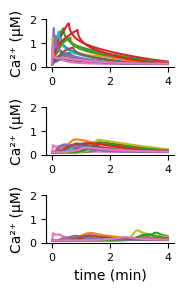

In [5]:
"""
For each parameter value where a sink was added, calcium concentration over time was stored and saved in last step at 
three distinct locations: i) Near the center of domain / initiator site ii) At the middle of overall wave propagation distance.
iii) At the end of teh wave trabel distance. In this part we visualzie the calicum concentartions extracted at different locations
of wave pro[pagation dostances.
"""

### Defining the simulation measurement times
T = 4  
dt = 0.00001  
time_steps = int(T / dt)
time = np.linspace(0, T, time_steps)

### Data visualization
fig, axs = plt.subplots(3, 1, figsize=(2, 3), dpi=100)
for j in range(len(ca_first_master)):
    axs[0].plot(time, ca_first_master[j,:])
    axs[1].plot(time, ca_middle_master[j,:])
    axs[2].plot(time, ca_last_master[j,:])
axs[2].set_xlabel('time (min)' , fontsize = 10)
for i in range(3):
    axs[i].set_ylabel('Ca²⁺ (µM)', fontsize = 10)
    axs[i].set_ylim(0,2)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

**Supplementary Figure 11Eii** *Representative Ca2+ signals at the site. Each color shows a fit for a particular parameter value.*

### Supplementary Figure 11A

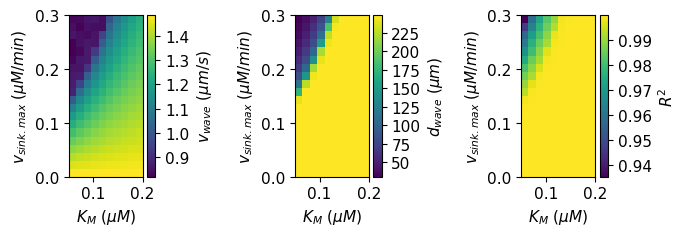

In [6]:
"""
Parameters KM and Vsink,max were varied within specified ranges. For each parameter combination,
we solved the CICR reaction diffusion model and calculated the wave velocity, distance travelled by wave and R2 value of
a linear model fit to the wave data. We use this data to visalize using a heatmap on how changing parametsrs "Vsinkmax"
and "KM" (sink params) affect the wave statiostics. Base parameter values of the CICR model used in these studies 
are σS = 3.34 μM/s, τS = 11.71 s, σ = 0,035 μM/s, τ = 25.08 s, d = 0.57 μm, CaT = 0.21 μM and Cab = 0.1 μM
"""

### Loading data
total_distance_array = np.load('km_vsinkmax_sampling/total_distance_array.npy')
r_squared_array = np.load('km_vsinkmax_sampling/r_squared_array.npy')
average_velocity_array = np.load('km_vsinkmax_sampling/average_velocity_arrayy.npy')

### Defining the range over which the parameters were varied
var1_range = np.linspace(0, 0.3, 20) #Vsink,max
var2_range = np.linspace(0.05, 0.2, 10) #KM
var1_label = r'$v_{sink.max}$ $(\mu M/min)$'
var2_label = r'$K_{M}$ $(\mu M)$'

### Data visualization
fig, axs = plt.subplots(1, 3, figsize=(7, 2.5), dpi=100)
im1 = axs[0].imshow(average_velocity_array/60, extent=[0.05, 0.2, 0, 0.3], aspect='auto', origin='lower', interpolation='nearest')
fig.colorbar(im1, ax=axs[0], label=r'$v_{wave}$ ($\mu m/s$)')
axs[0].set_xlabel(var2_label)
axs[0].set_ylabel(var1_label) 

im1 = axs[1].imshow(total_distance_array, extent=[0.05, 0.2, 0, 0.3], aspect='auto', origin='lower', interpolation='nearest')
fig.colorbar(im1, ax=axs[1], label=r'$d_{wave}$ ($\mu m$)')
axs[1].set_xlabel(var2_label)
axs[1].set_ylabel(var1_label) 

im1 = axs[2].imshow(r_squared_array, extent=[0.05, 0.2, 0, 0.3], aspect='auto', origin='lower', interpolation='nearest')
fig.colorbar(im1, ax=axs[2], label=r'$R^{2}$')
axs[2].set_xlabel(var2_label)
axs[2].set_ylabel(var1_label) 

plt.tight_layout()
plt.show()

**Supplementary Figure 11A** *(last plot) Parameters KM and Vsink,max were varied within specified ranges. For each parameter combination, we calculated the R2 values represented as a heatmap by fitting a line to the distances of CICR channels from the initiator site, plotted against their activation times Base parameter values of the CICR model used in these studies are σS = 3.34 μM/s, τS = 11.71 s, σ = 0,035 μM/s, τ = 25.08 s, d = 0.57 μm, CaT = 0.21 μM and Cab = 0.1 μM*